# Trabalho 3
Descrição do trabalho:

http://webserver2.tecgraf.puc-rio.br/~mgattass/visao/trb/T3.html

Aluno: Daniel da Silva Costa

E-mail: danieldasilvacosta@gmail.com

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
from keras.datasets import mnist
from keras.utils import np_utils
from sklearn import metrics
import pandas as pd

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

### Using PyTorch

Based on https://www.youtube.com/watch?v=oPhxf2fXHkQ&list=PLqnslRFeH2UrcDBWF5mfPGpqQDSta6VK4&index=13

#### Device configuration

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

#### Hyper-parameters 

In [3]:
input_size = 784 # 28x28
hidden_size = 500 
num_classes = 10
num_epochs = 5
batch_size = 256
learning_rate = 0.001

#### MNIST dataset 

In [4]:
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

#### Data loader

Creating the batches of the training set and test set.

In [5]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [6]:
train_loader

In [7]:
list(enumerate(train_loader))[0]

(0, [tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          ...,
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 

#### Depicting examples

From test set

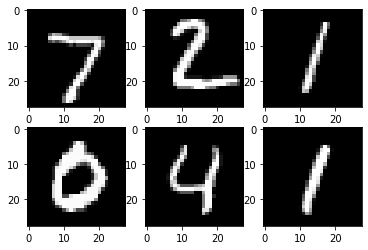

In [8]:
examples = iter(test_loader)
example_data, example_targets = examples.next()

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
plt.show()

#### Neural Network

In [9]:
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        # no activation and no softmax at the end
        return out

In [10]:
model = NeuralNet(input_size, hidden_size, num_classes).to(device)

#### Loss and optimizer

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

#### Training

In [12]:
%%time

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # origin shape: [100, 1, 28, 28]
        # resized: [100, 784]
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

Epoch [1/5], Step [100/235], Loss: 0.3320
Epoch [1/5], Step [200/235], Loss: 0.2650
Epoch [2/5], Step [100/235], Loss: 0.1704
Epoch [2/5], Step [200/235], Loss: 0.1696
Epoch [3/5], Step [100/235], Loss: 0.1230
Epoch [3/5], Step [200/235], Loss: 0.1038
Epoch [4/5], Step [100/235], Loss: 0.0624
Epoch [4/5], Step [200/235], Loss: 0.0943
Epoch [5/5], Step [100/235], Loss: 0.0592
Epoch [5/5], Step [200/235], Loss: 0.0861
CPU times: user 23.7 s, sys: 359 ms, total: 24 s
Wall time: 24 s


#### Testing

In [13]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

Accuracy of the network on the 10000 test images: 97.57 %


### Using the Numpy

#### Loss Functions

In [14]:
def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / np.size(y_true)

def binary_cross_entropy(y_true, y_pred):
    return np.mean(-y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred))

def binary_cross_entropy_prime(y_true, y_pred):
    return ((1 - y_true) / (1 - y_pred) - y_true / y_pred) / np.size(y_true)

#### Activation Functions

In [15]:
def tanh(x):
  return np.tanh(x)

def tanh_prime(x):
  return 1 - np.tanh(x) ** 2

In [16]:
def sigmoid(x):
  return 1/(1+np.exp(-x))

def sigmoid_prime(x):
  s = 1/(1+np.exp(-x))
  ds = s*(1-s)
  return ds

In [17]:
def relu(x):
  return np.maximum(0,x)

def relu_prime(x):
  return (x>0).astype(x.dtype)

#### class Layer

In [18]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, input):
        # TODO: return output
        pass

    def backward(self, output_gradient, learning_rate):
        # TODO: update parameters and return input gradient
        pass

#### class Activation(Layer)

In [19]:
class Activation(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, input):
        self.input = input
        return self.activation(self.input)

    def backward(self, output_gradient, learning_rate):
        return np.multiply(output_gradient, self.activation_prime(self.input))

#### class Dense(Layer)

In [20]:
class Dense(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size, 1)

    def forward(self, input):
        self.input = input
        self.output = np.dot(self.weights, self.input) + self.bias
        return self.output

    def backward(self, output_gradient, learning_rate):
        input_gradient = np.dot(self.weights.T, output_gradient)
        # print( f'output_gradient.shape: {output_gradient.shape}' )
        weights_gradients = np.dot(output_gradient, self.input.T)
        bias_gradients = np.sum(output_gradient, axis=0).reshape((1, -1))

        # update parameters
        # print( f'learning_rate: {learning_rate}' )
        # print( f'weights_gradients.shape: {weights_gradients.shape}' )
        self.weights -= learning_rate * weights_gradients
        self.bias -= learning_rate * bias_gradients
        return input_gradient 

#### function predict()

In [21]:
def predict(network, input):
    output = input
    for layer in network:
        output = layer.forward(output)
    return output

#### function train()

In [22]:
def train(network, loss, loss_prime, x_train, y_train, epochs = 1000, learning_rate = 0.01, batch_size = -1, verbose = True):

    if batch_size > -1: # training using batches

        n_samples = len(x_train)
        n_batches = n_samples//batch_size

        batch_list_x = list()
        batch_list_y = list()
        for k in range(n_batches):

              ini = k * batch_size
              end = (k + 1) * batch_size
              batch_x = x_train[ini:end]
              batch_y = y_train[ini:end]
              batch_list_x.append( batch_x )
              batch_list_y.append( batch_y )

        if (n_batches * batch_size < len(x_train)):

              batch_x = x_train[ n_batches * batch_size: ]
              batch_y = y_train[ n_batches * batch_size: ]
              batch_list_x.append( batch_x )
              batch_list_y.append( batch_y )

        inner_verbose = False
        for e in range(epochs):

            if(inner_verbose):
                print( '========================================' )
                print( f'epoch number: {e}' )

            epoch_error = 0
            if inner_verbose:
                batch_index = 0
            # for key, batch_x in enumerate(batch_list_x):
            for batch_x, batch_y in zip(batch_list_x, batch_list_y):

                if inner_verbose:
                    print( '-------------------------------------' )
                    print( f'batch index: {batch_index}' )

                y_pred_list = list()
                for key, x in enumerate(batch_x):

                    # forward
                    y_pred = predict(network, x)
                    # print( f'y_pred: {y_pred}' )

                    y_pred_list.append( y_pred )

                batch_error = loss(batch_y, y_pred_list)
                if inner_verbose:
                    print( f'batch_error: {batch_error}' )

                epoch_error += batch_error

                # backward
                grad = loss_prime(batch_y, y_pred_list) # b, n
                # print( f'grad.shape: {grad.shape}' )
                # print( f'grad[0]: {grad[0]}' )
                # print( f'grad[0][0]: {grad[0][0]}' )
                # print( f'grad[1][0]: {grad[1][0]}' )
                # print( f'grad[2][0]: {grad[2][0]}' )

                grad = np.sum(grad, axis=0)
                # grad /= len(batch_y)
                # print( f'grad.shape: {grad.shape}' )
                # print( f'grad[0]: {grad[0]}' )

                for layer in reversed(network):
                    grad = layer.backward(grad, learning_rate)

                if inner_verbose:
                    batch_index += 1

            epoch_error /= len(batch_list_x)
            if inner_verbose:
                # print( f'epoch_error /= len(batch_list_x): {epoch_error}' )
                print()
                print( f'epoch_error: {epoch_error}' )

            if verbose:
                if e % 100 == 0:
                    print(f"{e}/{epochs}, epoch_error={epoch_error:.15}")

    else: # training item by item (stochastic)

        for e in range(epochs):
            error = 0
            for x, y in zip(x_train, y_train):
                # forward
                y_pred = predict(network, x)

                # error
                error += loss(y, y_pred)

                # backward
                grad = loss_prime(y, y_pred)
                for layer in reversed(network):
                    grad = layer.backward(grad, learning_rate)

            error /= len(x_train)

            if verbose:
                if e % 100 == 0:
                    print(f"{e}/{epochs}, error={error:.3}")

#### Example: XOR

In [23]:
X = np.reshape([[0, 0], [0, 1], [1, 0], [1, 1]], (4, 2, 1))
Y = np.reshape([[0], [1], [1], [0]], (4, 1, 1))

##### Neural Network

In [24]:
network = [
    Dense(input_size = 2, 
          output_size = 3),
    Activation(activation = tanh, 
               activation_prime = tanh_prime),
    Dense(input_size = 3, 
          output_size = 1),
    Activation(activation = tanh,
               activation_prime = tanh_prime)
]

##### Training

In [25]:
%%time

train(network, 
      loss = mse, 
      loss_prime = mse_prime, 
      x_train = X, 
      y_train = Y, 
      epochs = 10000, 
      learning_rate = 0.1)

0/10000, error=0.42
100/10000, error=0.0047
200/10000, error=0.00165
300/10000, error=0.000975
400/10000, error=0.000684
500/10000, error=0.000524
600/10000, error=0.000423
700/10000, error=0.000355
800/10000, error=0.000304
900/10000, error=0.000266
1000/10000, error=0.000237
1100/10000, error=0.000213
1200/10000, error=0.000193
1300/10000, error=0.000177
1400/10000, error=0.000163
1500/10000, error=0.000151
1600/10000, error=0.000141
1700/10000, error=0.000132
1800/10000, error=0.000124
1900/10000, error=0.000117
2000/10000, error=0.00011
2100/10000, error=0.000105
2200/10000, error=9.96e-05
2300/10000, error=9.49e-05
2400/10000, error=9.07e-05
2500/10000, error=8.68e-05
2600/10000, error=8.32e-05
2700/10000, error=7.99e-05
2800/10000, error=7.68e-05
2900/10000, error=7.4e-05
3000/10000, error=7.13e-05
3100/10000, error=6.89e-05
3200/10000, error=6.66e-05
3300/10000, error=6.44e-05
3400/10000, error=6.24e-05
3500/10000, error=6.05e-05
3600/10000, error=5.87e-05
3700/10000, error=5.7e

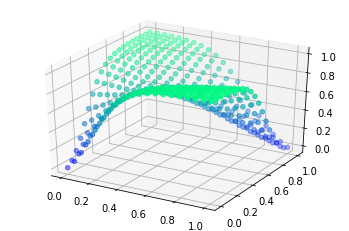

In [26]:
# decision boundary plot
points = []
for x in np.linspace(0, 1, 20):
    for y in np.linspace(0, 1, 20):
        z = predict(network, [[x], [y]])
        points.append([x, y, z[0,0]])

points = np.array(points)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=points[:, 2], cmap="winter")
plt.show()

#### Example: MNIST

In [27]:
# load MNIST from server
(x_train, y_train), (x_test, y_test) = mnist.load_data()

##### Loading the data

In [28]:
total_examples_train = 1000

In [29]:
total_examples_test = total_examples_train * .1
total_examples_test = int(total_examples_test)

In [30]:
x_train[0].shape

(28, 28)

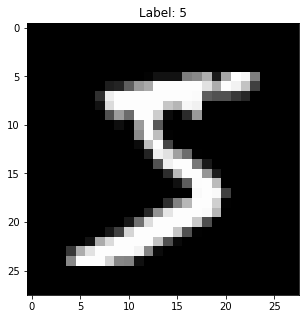

In [31]:
fig, axes = plt.subplots( 1, 1, figsize=( 10, 5 ) )

axes.set_title( f'Label: {y_train[0]}' )
axes.imshow( x_train[0], cmap='gray' )

plt.show()

In [32]:
x_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

##### Depicting examples

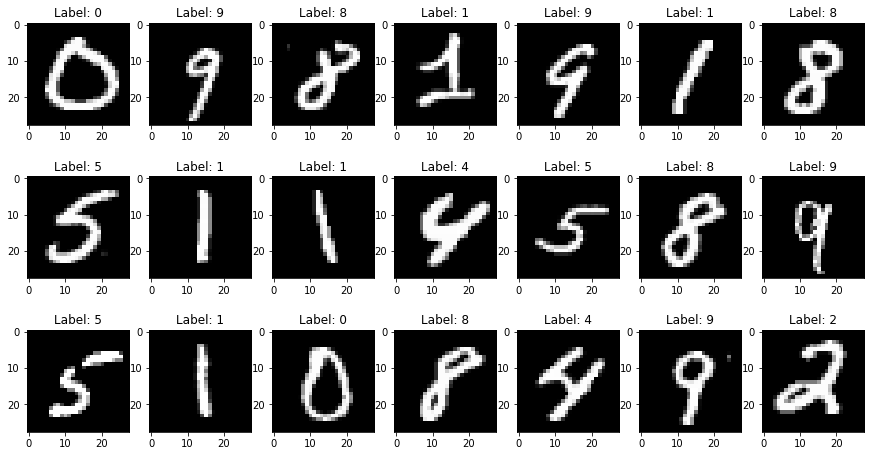

In [33]:
rows = 3
columns = 7

fig, axes = plt.subplots( rows, columns, figsize=( 15, 8 ) )

for i in range(rows):
  for j in range(columns):
    random_number = int(np.random.rand() * total_examples_train)
    axes[i][j].set_title( f'Label: {y_train[random_number]}' )
    axes[i][j].imshow( x_train[random_number], cmap='gray' )

plt.show()

##### Preprocessing Data

In [34]:
def preprocess_data(x, y, limit):
    # reshape and normalize input data
    x = x.reshape(x.shape[0], 28 * 28, 1)
    x = x.astype("float32") / 255
    # encode output which is a number in range [0,9] into a vector of size 10
    # e.g. number 3 will become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
    y = np_utils.to_categorical(y)
    y = y.reshape(y.shape[0], 10, 1)
    return x[:limit], y[:limit]

In [35]:
x_train, y_train = preprocess_data(x_train, y_train, total_examples_train)
x_test, y_test = preprocess_data(x_test, y_test, total_examples_test)

##### Neural Network

In [36]:
network = [
    Dense(input_size = 28 * 28, 
          output_size = 40),
    Activation(activation = tanh, 
               activation_prime = tanh_prime),
    Dense(input_size = 40, 
          output_size = 10),
    Activation(activation = tanh,
               activation_prime = tanh_prime),
]

##### Training

In [37]:
%%time

train(network, 
      loss = mse, 
      loss_prime = mse_prime, 
      x_train = x_train, 
      y_train = y_train, 
      epochs = 1000, 
      learning_rate = 0.1)
      # epochs = 100000, 
      # learning_rate = 1e-5,
      # batch_size = 256)

0/1000, error=0.889
100/1000, error=0.0747
200/1000, error=0.0613
300/1000, error=0.0549
400/1000, error=0.0502
500/1000, error=0.0456
600/1000, error=0.0407
700/1000, error=0.0369
800/1000, error=0.0352
900/1000, error=0.0332
CPU times: user 4min 3s, sys: 3min 11s, total: 7min 15s
Wall time: 3min 43s


##### Testing

In [38]:
print( f'len(y_test): {len(y_test)}' )

len(y_test): 100


In [39]:
%%time

y_predicted = list()
y_actual = list()

for x, y in zip(x_test, y_test):
    output = predict(network, x)

    y_predicted.append( np.argmax(output) )
    y_actual.append( np.argmax(y) )

    print('pred:', np.argmax(output), '\ttrue:', np.argmax(y))

pred: 7 	true: 7
pred: 6 	true: 2
pred: 1 	true: 1
pred: 0 	true: 0
pred: 4 	true: 4
pred: 1 	true: 1
pred: 4 	true: 4
pred: 9 	true: 9
pred: 6 	true: 5
pred: 7 	true: 9
pred: 0 	true: 0
pred: 8 	true: 6
pred: 9 	true: 9
pred: 0 	true: 0
pred: 1 	true: 1
pred: 8 	true: 5
pred: 4 	true: 9
pred: 7 	true: 7
pred: 9 	true: 3
pred: 4 	true: 4
pred: 9 	true: 9
pred: 6 	true: 6
pred: 3 	true: 6
pred: 8 	true: 5
pred: 4 	true: 4
pred: 0 	true: 0
pred: 7 	true: 7
pred: 4 	true: 4
pred: 0 	true: 0
pred: 1 	true: 1
pred: 3 	true: 3
pred: 1 	true: 1
pred: 3 	true: 3
pred: 0 	true: 4
pred: 7 	true: 7
pred: 3 	true: 2
pred: 4 	true: 7
pred: 1 	true: 1
pred: 2 	true: 2
pred: 1 	true: 1
pred: 3 	true: 1
pred: 7 	true: 7
pred: 4 	true: 4
pred: 9 	true: 2
pred: 5 	true: 3
pred: 8 	true: 5
pred: 8 	true: 1
pred: 7 	true: 2
pred: 8 	true: 4
pred: 2 	true: 4
pred: 6 	true: 6
pred: 9 	true: 3
pred: 8 	true: 5
pred: 8 	true: 5
pred: 8 	true: 6
pred: 0 	true: 0
pred: 4 	true: 4
pred: 1 	true: 1
pred: 9 	true:

###### Confusion Matrix

In [40]:
confusion_matrix = metrics.confusion_matrix(y_actual, y_predicted)
# print(confusion_matrix)

In [41]:
# based on https://www.statology.org/confusion-matrix-python/

y_actual = pd.Series(y_actual, name='Actual')
y_predicted = pd.Series(y_predicted, name='Predicted')

#create confusion matrix
print(pd.crosstab(y_actual, y_predicted))

Predicted  0   1  2  3  4  5  6   7  8  9
Actual                                   
0          8   0  0  0  0  0  0   0  0  0
1          0  11  0  1  0  1  0   0  1  0
2          0   0  3  1  0  0  1   2  0  1
3          0   0  0  6  0  2  1   0  0  2
4          1   0  1  0  9  0  0   0  3  0
5          0   0  0  0  0  0  1   1  5  0
6          0   0  0  1  0  0  6   0  3  0
7          0   0  0  0  1  0  0  13  0  1
8          0   0  1  0  0  0  0   0  1  0
9          0   0  0  0  1  0  0   2  3  5


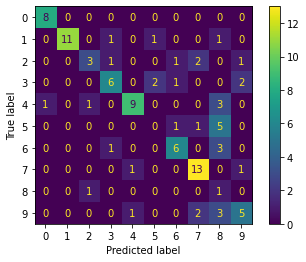

In [42]:
# based on https://www.w3schools.com/python/python_ml_confusion_matrix.asp

cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix, 
    display_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
cm_display.plot()
plt.show()

In [43]:
y_err = y_predicted[ y_predicted != y_actual ]
y_err[:20]

1     6
8     6
9     7
11    8
15    8
16    4
18    9
22    3
23    8
33    0
35    3
36    4
40    3
43    9
44    5
45    8
46    8
47    7
48    8
49    2
Name: Predicted, dtype: int64

#### Error Rate

"o valor da taxa de erro (calculada como o número de todas as previsões incorretas dividido pelo número total do conjunto de dados. A melhor taxa de erro é 0, enquanto a pior é 1.)"

In [44]:
error_rate = len(y_err) / total_examples_test
print( f'error_rate: {error_rate:.3}' )

error_rate: 0.38


In [45]:
error_rate_percentage = len(y_err) / total_examples_test * 100
print( f'error_rate_percentage: {error_rate_percentage:.3}%' )

error_rate_percentage: 38.0%
